In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA, KernelPCA

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.manifold import TSNE, LocallyLinearEmbedding

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, mean_squared_error
import seaborn as sns

## 1) Loading Data:

In [37]:
df = pd.read_csv(r"..\Dados\Tabela_final\tabela_final.csv")

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 0 to 1260
Data columns (total 64 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   IBGE7                1261 non-null   int64  
 1   UF                   1261 non-null   object 
 2   NOME                 1261 non-null   object 
 3   LATITUDE             1261 non-null   float64
 4   LONGITUDE            1261 non-null   float64
 5   DIST_EF_PUB          1261 non-null   float64
 6   DIST_EM_PUB          1261 non-null   float64
 7   IDEB_AI              1261 non-null   float64
 8   IDEB_AF              1261 non-null   float64
 9   DOCSUP_EF_PUB        1261 non-null   float64
 10  DOCSUP_EM_PUB        1261 non-null   float64
 11  TXNASC7C             1261 non-null   float64
 12  TXNBAIXOP            1261 non-null   float64
 13  PINTERSAP            1261 non-null   float64
 14  PINTERDRSAI          1261 non-null   float64
 15  REN_PIBPC_D          1261 non-null   f

In [39]:
lista_colunas = [coluna for coluna in df.columns if (df[coluna].dtype == 'float64')&(coluna not in ['LATITUDE', 'LONGITUDE'])]

In [40]:
#df_final_merged = df[lista_colunas]

In [41]:
df_final_merged = pd.read_csv(r"..\Dados\Tabela_final\df_selecionado_cluster.csv")

In [42]:
df_final_merged = df[df_final_merged.columns]

In [43]:
df_final_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 0 to 1260
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DIST_EF_PUB        1261 non-null   float64
 1   DIST_EM_PUB        1261 non-null   float64
 2   IDEB_AI            1261 non-null   float64
 3   IDEB_AF            1261 non-null   float64
 4   DOCSUP_EF_PUB      1261 non-null   float64
 5   DOCSUP_EM_PUB      1261 non-null   float64
 6   TXNASC7C           1261 non-null   float64
 7   REN_PIBPC_D        1261 non-null   float64
 8   PDEFAGUA           1261 non-null   float64
 9   PDEFESGOTO         1261 non-null   float64
 10  PANALF15           1261 non-null   float64
 11  PIND_POS           1261 non-null   float64
 12  POP_TOT_30KM       1261 non-null   float64
 13  IDHM               1261 non-null   float64
 14  T_BANAGUA          1261 non-null   float64
 15  T_DENS             1261 non-null   float64
 16  T_LUZ              1261 

## 2) Preprocessamento

### 2.1) Scalling

#### 2.1.1) StandardScaler

In [44]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_final_merged)

In [45]:
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df_final_merged.columns

### 2.2) Dimensionality Reduction

In [46]:
def reconstruction_erro(df_normal, df_pca,  pca_model):
    df_inversed = pca_model.inverse_transform(df_pca)
    reconstruction_error = mean_squared_error(df_normal, df_inversed)
    return reconstruction_error

#### 2.2.1) PCA

In [47]:
pca = PCA(n_components=0.95)
df_pca = pca.fit_transform(df_scaled)

Número de componentes para 0.95 de variância: 24


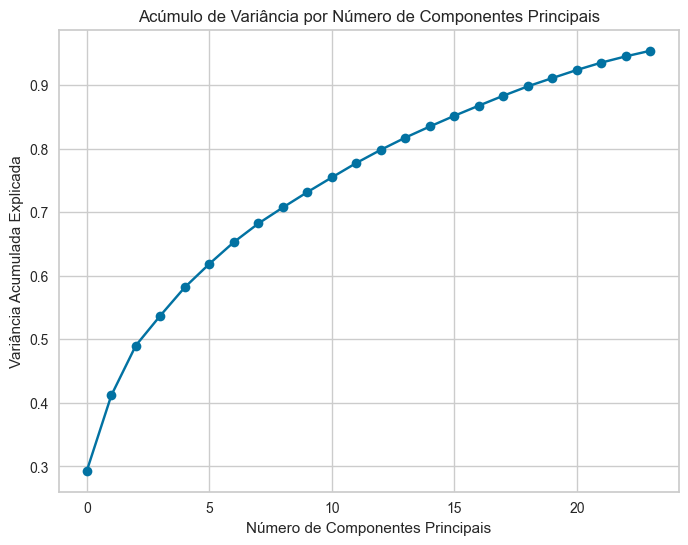

In [48]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# Crie um gráfico para visualizar o acúmulo de variância
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o', linestyle='-')
print("Número de componentes para 0.95 de variância:", df_pca.shape[1])
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Acumulada Explicada')
plt.title('Acúmulo de Variância por Número de Componentes Principais')
plt.grid(True)
plt.show()


In [49]:
# Reconstruction error:
print(f"Reconstruction error PCA: {reconstruction_erro(df_scaled, df_pca, pca)}")

Reconstruction error PCA: 0.046198918364983785


#### 2.2.2) T-SNE

In [50]:
def plot_clusters(df, df_components, clusters):
    df[['COMPONENT1', 'COMPONENT2']] = df_components
    df['CLUSTER'] = clusters

    actual_cities = df[['NOME', 'COMPONENT1', 'COMPONENT2', 'CLUSTER']].loc[df['NOME'].isin(['MAURITI', 'SÃO JOSÉ DA TAPERA', 'BUÍQUE', 'INAJÁ'])]

    print(actual_cities)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='COMPONENT1', y='COMPONENT2', hue='CLUSTER', palette='Set2')
    sns.scatterplot(data=actual_cities, x='COMPONENT1', y='COMPONENT2', marker = 'X', color='black', s=100, label='Cidades atuais')
    for i, row in actual_cities.iterrows():
        plt.text(row['COMPONENT1'] + 0.1, row['COMPONENT2'], row['NOME'], fontsize=12)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.title('Visualização dos Clusters')
    plt.legend(title='Cluster', loc='upper right')
    plt.grid(True)
    plt.show()

In [51]:
tsne = TSNE(n_components=2, random_state=42)
df_components = tsne.fit_transform(df_pca)

#### 2.2.3) Kernel PCA

In [52]:
kernel_pca = KernelPCA(n_components=24, kernel='rbf', gamma=0.04, fit_inverse_transform=True)
df_kernel_pca = kernel_pca.fit_transform(df_scaled)

In [53]:
# Reconstruction error:
print(f"Reconstruction error Kernel PCA: {reconstruction_erro(df_scaled, df_kernel_pca, kernel_pca)}")

Reconstruction error Kernel PCA: 0.4175836212768839


#### 2.2.4) Locally Linear Embedding (LLE)

In [54]:
lle = LocallyLinearEmbedding(n_components=24, n_neighbors=5)
df_lle = lle.fit_transform(df_scaled)

In [55]:
# Reconstruction error:
print(f"Reconstruction error LLE: {reconstruction_erro(df_scaled, df_lle, kernel_pca)}")

Reconstruction error LLE: 1.0870604004925297


### 2.3) Kmeans:

#### 2.3.1) Elbow curve

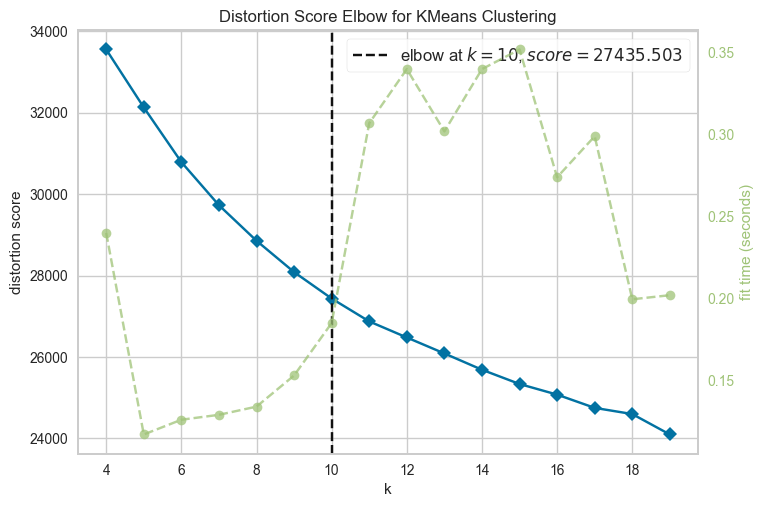

In [56]:
model = KMeans(n_init=20, random_state=42)
visualizer = KElbowVisualizer(model, k=(4,20))
visualizer.fit(df_pca)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

#### 2.3.2) Silhouette_score

In [57]:
def best_silhuet_score(data):
    best_silhuet = 0
    best_k = 0
    for i in range(2, 21):
        kmean = KMeans(n_clusters=i, n_init=20, random_state=42)
        centroids = kmean.fit_transform(df_pca)
        score = silhouette_score(df_pca, kmean.labels_)
        if score > best_silhuet:
            best_silhuet = score
            best_k = i
        
    return best_k, best_silhuet

In [58]:
best_k, best_silhuet = best_silhuet_score(df_pca)

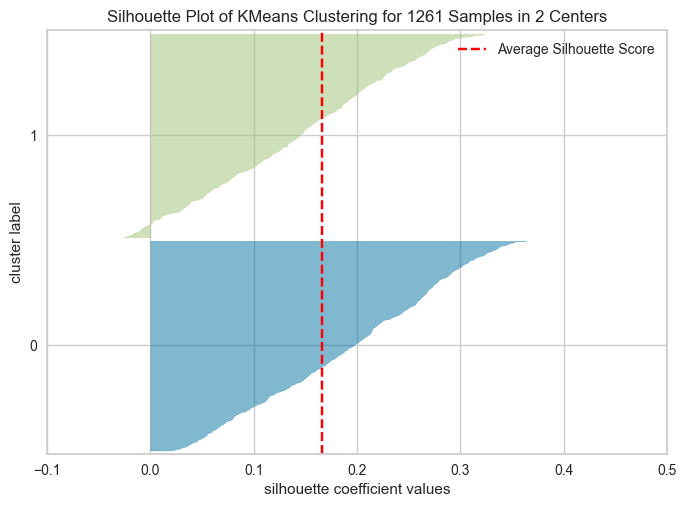

Silhouette avg: 0.16572885363281367


In [59]:
kmean = KMeans(n_clusters=best_k, n_init=20, random_state=42)
visualizer = SilhouetteVisualizer(kmean, colors="yellowbrick")
visualizer.fit(df_pca)
visualizer.show();
print("Silhouette avg:", visualizer.silhouette_score_)

#### 2.3.3) Métricas finais:

Silhouette Score:  0.1657
Davies-Bouldin Score:  1.9675
Calinski-Harabasz Index:  305.7443
                   NOME  COMPONENT1  COMPONENT2  CLUSTER
34   SÃO JOSÉ DA TAPERA   30.111261  -13.126927        1
418             MAURITI  -17.154957  -18.436186        0
796              BUÍQUE   32.525124  -14.259306        1
827               INAJÁ   35.573025  -14.520339        1


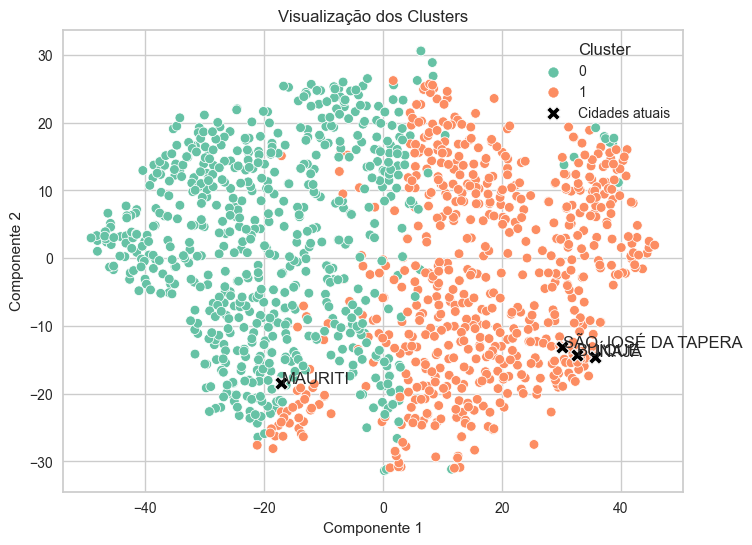

In [66]:
kmeans = KMeans(2, random_state = 42, n_init=20)
clusters = kmeans.fit_predict(df_pca)
print('Silhouette Score: ',round(silhouette_score(df_pca, clusters), 4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_pca, clusters), 4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_pca, clusters), 4))
plot_clusters(df, df_components, clusters)

Como o Kmeans foi satisfatório deviso as suas métricas, iremos utilizar suas labels para treinar um modelo de classificação e, com isto, observar quais são as features mais relevantes para a clusterização

In [61]:
#df_final_maci['Labels'] = kmeans.labels_

In [62]:
#df_final_maci.to_csv(r"..\Dados\Tabela_final\tabela_final_com_cluster.csv", index=False)

### 2.4) Hirarchical clustering:

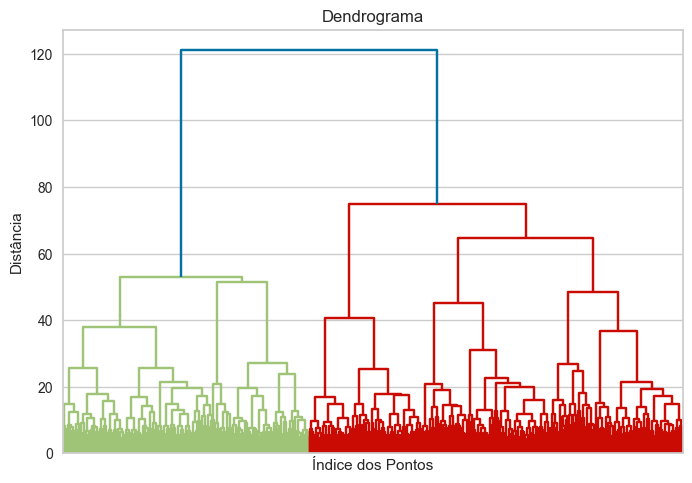

In [63]:
linkage_matrix = linkage(df_pca, method='ward')

plt.figure()
dendrogram(linkage_matrix)
plt.title('Dendrograma')
plt.xticks([])
plt.xlabel('Índice dos Pontos')
plt.ylabel('Distância')
plt.show()

Silhouette Score:  0.057
Davies-Bouldin Score:  2.7471
Calinski-Harabasz Index:  124.0792
                   NOME  COMPONENT1  COMPONENT2  CLUSTER
34   SÃO JOSÉ DA TAPERA   30.111261  -13.126927        1
418             MAURITI  -17.154957  -18.436186        2
796              BUÍQUE   32.525124  -14.259306        1
827               INAJÁ   35.573025  -14.520339        1


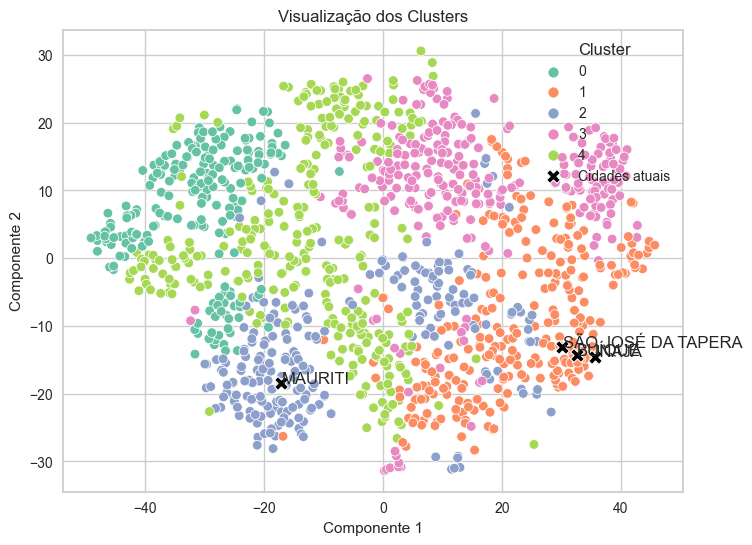

In [64]:
hclustering = AgglomerativeClustering(n_clusters=5)
clusters = hclustering.fit_predict(df_pca)
print('Silhouette Score: ',round(silhouette_score(df_pca, clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_pca, clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_pca, clusters),4))
plot_clusters(df, df_components, clusters)